In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sat Apr  4 19:30:28 2020

@author: mor
"""

import pandas as pd
import numpy as np
import json
import folium
import datetime
import tempfile 
import webbrowser, os
from folium.plugins import Draw,Search,MousePosition 
import geopandas as gpd
import geojson as gj
import math
from geopy.distance import geodesic
from shapely.geometry import Polygon, Point, LinearRing ,MultiLineString
import pickle
import shapely.wkt as swkt
import pyproj
from functools import partial
from shapely.ops import transform

In [2]:

pd.set_option('display.max_columns', 8)


In [3]:

BASE = os.path.dirname(os.getcwd())
HTML= os.path.join(BASE,'html')
DATA = os.path.join(BASE,'data')
POLYGONS=os.path.join(DATA,'polygons')
SHAPE = os.path.join(BASE,'shape')
OSM = os.path.join(BASE,'osm')

In [4]:

#swap lat lng positions
def swapCoord(li):
    arr=np.array(li)
    newli=[]
    if li:
        if len(arr.shape)==2:
            newli=list(arr[:,[1,0]])
        if len(arr.shape)==1:
            newli=[arr[1],arr[0]]
    return newli
  

#open folium in the browser - new tab
def open_in_browser(m,filename=None,dir_file=HTML):
    tmp=tempfile.NamedTemporaryFile(delete=False)
    now = datetime.datetime.now()
    timenow='_'+str(now.strftime("%Y-%m-%d_%H%M"))
    if filename:
        path=filename+timenow+'.html'
        path=os.path.join(dir_file, path)
    else:
        path=tmp.name+'.html'
        
    m.save(path)
    webbrowser.open('file://' + path)


#get json path of polygons 
def get_json(path=POLYGONS):
    for name in os.listdir(path):
        if name.endswith('.json') and name[-6].isdigit():
            yield os.path.join(path, name)

#get json of polygon
def read_json(path):
    io = open(path,encoding='utf-8')
    geo_json_data = json.load(io)
    return  geo_json_data

#get json by semel number 
def get_json_by_number(numbers,path=POLYGONS):
    numbers_str =[str(x) for x in numbers]
    for name in os.listdir(path):
        if name.endswith('.json') and name[:-5] in numbers_str:
              yield os.path.join(path, name) 

#check if polygon exists in the data
def check_polygon_exists(number,path=POLYGONS):
    number_str =str(number)
    for name in os.listdir(path):
        if name.endswith('.json') and name[:-5] == number_str:
            return True
    return False

#fix polygons with overlap coordinates
def fix_geometry(poly,buffer=0.):
    if not poly.is_valid:
        return poly.buffer(buffer)
    else:
        return poly




###  Read all cities - הלמס


In [5]:

#read cities list - names in hebrew and english and semel number
df=pd.read_excel(DATA+'/cities.xls')
df.head()


שם יישוב         תעתיק שם יישוב באנגלית   סמל
0  אבו ג'ווייעד  ABU JUWEI'ID      Abu Juway'ad  967
1       אבו גוש     ABU GHOSH         Abu Ghosh  472
2      אבו סנאן     ABU SINAN         Abu Sinan  473
3    אבו סריחאן  ABU SUREIHAN      Abu Surayhan  935
4     אבו עבדון    ABU  ABDUN        Abu 'Abdun  958

In [6]:

df.dropna(subset=(['תעתיק']),inplace=True)
df.columns=['city','eng1','eng2','semel']    


In [7]:

semel= df[df.city=='נתניה'].semel.values[0]
data=list(read_json(list(get_json_by_number([semel]))[0]).values())[0]




###  Minimun distance from point to polygon in gps wgs84 coordinates


In [8]:

from geopy.distance import geodesic
from shapely.geometry import Polygon, Point, LinearRing

lat=32.2876
lon=34.8443
coordinate=[lat,lon]
polylist=swapCoord(data['geojson']['coordinates'][0])



In [9]:

#min distance between point and polygon. return the closest point and disntace in meters
def minDistancePointToPolygon(point_coord,polylist):
    """
    :param point_coord: coordinate of a point (Latitude,Longitude) [get list or shapely Point]
    :param polylist: coordinate of polygon (Latitude,Longitude) [get list or shapely Polygon]
    :return: minimum distance between point and polygon and the closest point coordinates
    *geodesic meters calculate two distnace between two point in format (Latitude,Longitude)
    """
    if isinstance(polylist, (list,)):
        poly = Polygon(polylist)
    else:
        poly=polylist
    
    if isinstance(point_coord, (list,)):
        point = Point(point_coord)
    else:
        point = point_coord
    
    if poly.type=='MultiPolygon':
        min_dist=1e10
        for g in poly:
            pol_ext = LinearRing(g.exterior.coords)
            d = pol_ext.project(point)
            p = pol_ext.interpolate(d)
            closest_point_coords = (p.x,p.y)
            dist=geodesic(closest_point_coords,(point.x,point.y)).meters
            if min_dist>dist:
                min_dist=dist
                closest_point=closest_point_coords
        return closest_point,min_dist
    
    else:
        pol_ext = LinearRing(poly.exterior.coords)
        d = pol_ext.project(point)
        p = pol_ext.interpolate(d)
        closest_point_coords = (p.x,p.y)
        return closest_point_coords,geodesic(closest_point_coords,(point.x,point.y)).meters



In [10]:

minCoord,dist = minDistancePointToPolygon(coordinate,polylist)
print('Closest point coordinates: {} , Distance(meters): {}'.format(minCoord,dist) )


Closest point coordinates: (32.289541817112685, 34.83708951505801) , Distance(meters): 712.5157884646156


### Minimum distance on map

In [11]:

from folium.plugins import Draw,Search,MousePosition 
  
m = folium.Map(coordinate, zoom_start=13)

folium.Marker(coordinate,popup=str(coordinate)).add_to(m)

folium.GeoJson(data['geojson']).add_to(m)

for coord in swapCoord(data['geojson']['coordinates'][0]):
    folium.Marker(coord,popup=str(coord),icon=folium.Icon(color='green')).add_to(m)

folium.Marker(minCoord,popup=str(minCoord),icon=folium.Icon(color='red')).add_to(m)

folium.PolyLine([coordinate,minCoord], color="red", weight=2.5, opacity=1).add_to(m)

draw = Draw()
draw.add_to(m)

#open_in_browser(m)
m


###  Display polygons of the cities in israel


In [12]:

m = folium.Map(location=[32.2530, 34.7915], zoom_start=10) 

for i, json_path in enumerate(get_json(path=POLYGONS)):
    geo_json_data = read_json(json_path)
    key=list(geo_json_data.keys())[0]
    val=list(geo_json_data.values())[0]
    
    geoj=folium.GeoJson(val['geojson'])
    popup = folium.Popup(key+'-'+val['display_name']+'-'+df[df.semel==int(key)].city.values[0])
    popup.add_to(geoj)
    geoj.add_to(m)
    if i<10:
        print(val['display_name']+'-'+df[df.semel==int(key)].city.values[0])
        print(key)
open_in_browser(m) 


תירוש, מחוז ירושלים, ישראל-תירוש
10
מבשרת ציון, מחוז ירושלים, ישראל-מבשרת ציון
1015
כפר הנוער מאיר שפיה, מחוז חיפה, ישראל-מאיר שפיה
102
אור עקיבא, מחוז חיפה, ישראל-אור עקיבא
1020
חרוצים, מחוז המרכז, ישראל-חרוצים
1024
תל עדשים, מחוז הצפון, ישראל-תל עדשים
103
שדרות, מחוז הדרום, ישראל-שדרות
1031
קרית מלאכי, מחוז הדרום, ישראל-קריית מלאכי
1034
מזרע, מחוז הצפון, ישראל-מזרע
104
נצאצרה, מחוז הדרום, ישראל-נצאצרה
1041



### Transform coordinates from meters to degrees and vice versa 


In [13]:


import pyproj
from functools import partial
from shapely.ops import transform

def epsg_3857_to_4326(coord):
    """
    :param coord: coordinate of a point (Latitude,Longitude) or (Longitude,Latitude) 
    :return: Transform points between two coordinate systems (4326 - WGS84 , 3857 - metric coordinates)
    """
    x1,y1 = coord    
    inProj = pyproj.Proj(init='epsg:3857')
    outProj = pyproj.Proj(init='epsg:4326')
    x2,y2 = pyproj.transform(inProj,outProj,x1,y1)
    return [x2,y2]

def epsg_4326_to_3857(coord):
    """
    :param coord: coordinate of a point (Latitude,Longitude) or (Longitude,Latitude) 
    :return: Transform points between two coordinate systems (4326 - WGS84 , 3857 - metric coordinates)
    """
    x1,y1 = coord    
    inProj = pyproj.Proj(init='epsg:4326')
    outProj = pyproj.Proj(init='epsg:3857')
    x2,y2 = pyproj.transform(inProj,outProj,x1,y1)
    return [x2,y2]


def epsg_3857_to_4326_shapely(geom):
    """
    :param geom: shapely geometry
    :return: Transform shapely geometry between two coordinate systems (4326 - WGS84 , 3857 - metric coordinates)
    """
    project = partial(
        pyproj.transform,
        pyproj.Proj(init='epsg:3857'), # source coordinate system
        pyproj.Proj(init='epsg:4326')) # destination coordinate system
    return transform(project,geom)


def epsg_4326_to_3857_shapely(geom):
    """
    :param geom: shapely geometry
    :return: Transform shapely geometry between two coordinate systems (4326 - WGS84 , 3857 - metric coordinates)
    """
    project = partial(
        pyproj.transform,
        pyproj.Proj(init='epsg:4326'), # source coordinate system
        pyproj.Proj(init='epsg:3857')) # destination coordinate system
    return transform(project,geom)



In [14]:

c=epsg_4326_to_3857([31.2530, 34.7915])
epsg_3857_to_4326(c)


[31.252999999999997, 34.79149999999999]

In [15]:

p=epsg_4326_to_3857_shapely(Point([31.2530, 34.7915]))
print([p.x,p.y])
p=epsg_3857_to_4326_shapely(p)
print([p.x,p.y])


[3479068.0457621785, 4135582.802172641]
[31.252999999999997, 34.79149999999999]


In [16]:

semel= df[df.city=='באר שבע'].semel.values[0]

#get polygons data by semel number
def get_polygons_by_semel(semels):
    """
    :param semels: list of numbers. each number represent semel of city
    :return: data- list of polygons coordinates for each city semel  
    :return: empty_data- list of city semel that polygon not exists
    """
    data=[]
    empty_data=[]
    for semel in semels:
        if check_polygon_exists(semel):
            j = list(get_json_by_number([semel]))[0]
            data.append(read_json(j))
        else:
            empty_data.append(semel)
    return data,empty_data


In [17]:

semels=[semel,7400,0]
data=get_polygons_by_semel(semels)[0][0]

data_list,empty_data_list=get_polygons_by_semel(semels)


#### Save and load object as pickle

In [18]:

import pickle

#save pickle 
def save_obj(obj,filename, path = DATA ):
    """
    :param obj: object that we want to save
    :param filename: filename for pickle
    :param path: path for where to save
    """
    with open(path+'\\'+ filename + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

#load pickle
def load_obj(filename, path = DATA ):
    """
    :param filename: filename for pickle
    :param path: path for where to save
    :return: object - unpickle
    """
    with open( path+'\\'+ filename + '.pkl', 'rb') as f:
        return pickle.load(f)



In [19]:
      
semel_dict=df[['semel','city']].set_index('semel').to_dict()['city']
#save_obj(semel_dict,'semel_dict')


In [20]:

#load semel dictionary
semel_dict=load_obj('semel_dict')



### Load json files to geo pandas dataframe


In [21]:

import geopandas as gpd
import geojson as gj

def get_geo_pandas(data_list,semel_dict):
    """
    :param data_list: list of geojson
    :param semel_dict: dictonary of semel city and name of city
    :return: gdf - geodataframe contains the cities and there polygons
    """
    geofeatures=[]
    for data in data_list:
        semel=int(list(data.keys())[0])
        features=list(data.values())[0]
        if features['geojson']['type']=='Polygon':
            geometry=gj.Polygon(features['geojson']['coordinates'])
        elif features['geojson']['type']=='MultiPolygon':
            geometry=gj.MultiPolygon(features['geojson']['coordinates'])
        display_name=features['display_name']
        city=semel_dict[semel]
        geofeatures.append(gj.Feature(geometry=geometry, properties={'semel':semel,'display_name':display_name,'city':city}))
    gdf=gpd.GeoDataFrame.from_features(gj.FeatureCollection(geofeatures)['features'])
    gdf.crs = {'init': 'epsg:4326', 'no_defs': True}
    gdf['geometry']=gdf.apply(lambda row: fix_geometry(row.geometry),axis=1)
    return gdf


In [22]:

gdf=get_geo_pandas(data_list,semel_dict)


In [23]:

import numpy as np
from shapely.geometry import shape, mapping

import shapely.wkt as swkt
from shapely.geometry import shape, mapping,  MultiPolygon

#round the coordinates
def around(geom,round_value):
    return swkt.loads(swkt.dumps(geom, rounding_precision=round_value))

#gdf.geometry= gdf.geometry.apply(lambda x: around(x,3))


### Calculate centroid of geometry data form geopandas type

In [24]:
 
def center_of_geometry_gpd(gdf):
    gdf_3857 = gdf.to_crs(epsg = 3857)
    gdf_center = gdf_3857.geometry.centroid
    gdf['center']=gdf_center.to_crs(epsg = 4326)
    return gdf

# calculate centroid of geometry data form shapely type
def center_shapely_coord(poly):
    coord=list(poly.centroid.coords)[0]
    return coord
    
gdf=center_of_geometry_gpd(gdf)

### Folium polygon with center

In [25]:

point = gdf.center.iloc[0]
folium_loc = [point.y, point.x]
m = folium.Map(location = folium_loc, zoom_start= 13)
folium.GeoJson(gdf.geometry).add_to(m)
folium.Marker(folium_loc).add_to(m)
#open_in_browser(m)
m

### Create less accurate grid in polygon

In [26]:

import math

minx,miny,maxx,maxy=gdf.geometry.to_crs(epsg = 3857).bounds.values.squeeze()[0]

dx = 500*1.1627906976744187
dy = 500*1.1627906976744187


nx = int(math.ceil(abs(maxx - minx)/dx))
ny = int(math.ceil(abs(maxy - miny)/dy))


id=0
parts = []
for i in range(ny):
    for j in range(nx):
        id+=1
        vertices = []
        
        vertices.append(epsg_3857_to_4326([min(minx+dx*j,maxx),max(maxy-dy*i,miny)]))
        vertices.append(epsg_3857_to_4326([min(minx+dx*(j+1),maxx),max(maxy-dy*i,miny)]))
        vertices.append(epsg_3857_to_4326([min(minx+dx*(j+1),maxx),max(maxy-dy*(i+1),miny)]))
        vertices.append(epsg_3857_to_4326([min(minx+dx*j,maxx),max(maxy-dy*(i+1),miny)]))
        
        parts.append(vertices)


In [27]:

data={'type': 'Polygon','coordinates' : parts}

m = folium.Map(location=[31.2530, 34.7915], zoom_start=12) 
geoj=folium.GeoJson(data)
geoj.add_to(m) 
draw = Draw()
draw.add_to(m)
#open_in_browser(m)
m


In [28]:

from shapely.geometry import Point
import pyproj

def create_grid_for_polygons(polygon,stepsize_x,stepsize_y):
    """
    :param polygon: polygons in shapely format
    :param stepsize_x: size of cell in x
    :param stepsize_y: size of cell in y
    :return: grid - dictionary, key grid id and value is polygons(squre)
    """
    #x in longitude and y is latitude
    minx,miny,maxx,maxy=polygon.bounds       

    # Create corners of rectangle in meters format
    s = epsg_4326_to_3857([minx,miny]) # Transform point to 3857 crs
    e = epsg_4326_to_3857([maxx,maxy]) # .. same maximun coordinates
    
    # Iterate over 2D area
    y = s[1]
    id=0
    grid={}
    while y < e[1]:
        x = s[0]
        while x < e[0]:    
            p1 = epsg_3857_to_4326([min(x,e[0]), min(y,e[1])])
            p2 = epsg_3857_to_4326([min(x,e[0]), min(y+stepsize_y,e[1])])
            p3 = epsg_3857_to_4326([min(x+stepsize_x,e[0]), min(y+stepsize_y,e[1])])
            p4 = epsg_3857_to_4326([min(x+stepsize_x,e[0]), min(y,e[1])])
            poly=Polygon([p1,p2,p3,p4])
            if polygon.intersects(poly):# check if grid cell inside the main polygon
                grid[str(id)]=poly
                id+=1
            
            x += stepsize_x
        y += stepsize_y
    return grid


In [29]:
dy=dx=500 

#add grid to geopandas data frame  
gdf['grid']=gdf.apply(lambda row: create_grid_for_polygons(row.geometry ,dx,dy),axis=1)


In [30]:

m = folium.Map(location=[31.2530, 34.7915], zoom_start=12) 
for ind,row in gdf.iterrows():
    folium.GeoJson(row['geometry']).add_to(m)
    for key,poly in row['grid'].items():
        geoj=folium.GeoJson(poly)
        popup = folium.Popup(str('semel: '+str(row['semel'])+' - key: '+str(key)))
        popup.add_to(geoj)
        geoj.add_to(m) 

draw = Draw()
draw.add_to(m)  
#open_in_browser(m)
m



#### Display geometry in picture


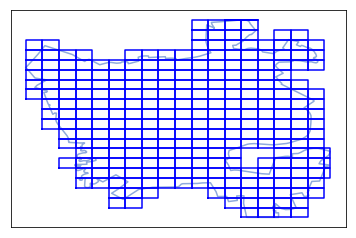

In [31]:
%matplotlib inline

import matplotlib.colors as plt_color
import matplotlib.pyplot as plt

poly=gdf.geometry.iloc[0]
grid_list=[ (key,poly) for key, poly in gdf.grid.iloc[0].items()]


x,y = poly.exterior.xy
plt.plot(x,y,color='#8FAADC')
for k,p in grid_list:
    x,y = p.exterior.xy
    plt.plot(x,y,color='blue')
plt.xticks([])
plt.yticks([])

#plt.savefig('model_example.png')
plt.show()



#### Display geometry in picture with tile background


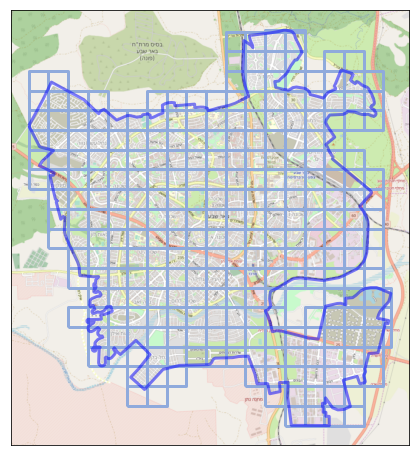

In [32]:

import contextily

#Need metrics crs - convert to 3857
gdf_3857=gdf.to_crs(epsg=3857).iloc[[0]]

grid_list=[ (key,epsg_4326_to_3857_shapely(poly)) for key, poly in gdf_3857.grid.squeeze().items()]

df_grid=pd.DataFrame(grid_list,columns=['key','geometry'])
gdf_grid=gpd.GeoDataFrame(df_grid,crs=gdf_3857.crs,geometry=df_grid.geometry)


ax=gdf_grid.plot(facecolor='none', edgecolor='#8FAADC', linewidth=3,figsize=(8, 8))
gdf_3857.plot(ax=ax,edgecolor='blue',alpha=0.5,facecolor='none', linewidth=3)
#ax.set_axis_off()
plt.xticks([])
plt.yticks([])
contextily.add_basemap(ax=ax,url=contextily.sources.OSM_A)
#plt.savefig('model_example.png')
plt.show()


In [33]:

def create_circle(center_4326,radius):
    '''
    Create circle by coordinates in shapely object in format of (longitude,latitue) and radius in meters 
    Return circle polygon
    '''
    center_3857=epsg_4326_to_3857_shapely(center_4326)
    circle = center_3857.buffer(radius)
    return Polygon([epsg_3857_to_4326(coord) for coord in list(circle.exterior.coords)])
   

In [34]:

radius=500
data=gdf.iloc[0].geometry
center=gdf.iloc[0].center
newCircle= create_circle(center,radius)

coordinate=[center.y,center.x]
coordinate2=center_shapely_coord(newCircle)
coordinate2=swapCoord(coordinate2)
print('check conversion coordinates shift:\n' ,geodesic(coordinate,coordinate2).meters)


check conversion coordinates shift:
 0.006485936066846425


#### Folium - circle display

In [35]:
   
from folium.plugins import Draw,Search,MousePosition 
  
m = folium.Map(coordinate, zoom_start=15)

style_function=lambda feature,fillColor='red': {
        'fillColor': fillColor ,
        'color': 'black',
        'weight': 1,
        'dashArray': '5, 5'
    }

folium.Marker(coordinate,popup=str(coordinate)).add_to(m)
folium.Marker(coordinate2,popup=str(coordinate2),icon=folium.Icon(color='green')).add_to(m)

folium.GeoJson(data).add_to(m)
folium.GeoJson(newCircle,style_function=style_function).add_to(m)

draw = Draw()
draw.add_to(m) 
     
#open_in_browser(m)      

m

In [36]:

# swap coordinates for any shapely geometry types
def swap_xy(geom):
    if geom.is_empty:
        return geom

    if geom.has_z:
        def swap_xy_coords(coords):
            for x, y, z in coords:
                yield (y, x, z)
    else:
        def swap_xy_coords(coords):
            for x, y in coords:
                yield (y, x)

    # Process coordinates from each supported geometry type
    if geom.type in ('Point', 'LineString', 'LinearRing'):
        return type(geom)(list(swap_xy_coords(geom.coords)))
    elif geom.type == 'Polygon':
        ring = geom.exterior
        shell = type(ring)(list(swap_xy_coords(ring.coords)))
        holes = list(geom.interiors)
        for pos, ring in enumerate(holes):
            holes[pos] = type(ring)(list(swap_xy_coords(ring.coords)))
        return type(geom)(shell, holes)
    elif geom.type.startswith('Multi') or geom.type == 'GeometryCollection':
        # Recursive call
        return type(geom)([swap_xy(part) for part in geom.geoms])
    else:
        raise ValueError('Type %r not recognized' % geom.type)


#get grid and radius and return circle for each grid cell
def create_circle_for_grid(grid,radius):
    circle_grid={}
    for key,poly in grid.items():
        center_4326=center_shapely_coord(poly)
        circle=create_circle(Point(center_4326),radius)        
        circle_grid[key]=circle
    
    return circle_grid


#distance between grid and polygon. intersection grid cell and polygons distance equal zero      
def grid_distance_from_polygons(grid,polygon):
    grid_distance={}
    for key,poly in grid.items():
        center_4326=center_shapely_coord(poly)
        p,dist = minDistancePointToPolygon(swapCoord(center_4326),swap_xy(polygon))
        if polygon.boundary.intersects(poly):
            dist=0
        grid_distance[key]=(p,dist)
    
    return grid_distance


In [37]:

#add grid circle to geopandas data frame 
gdf['circle_grid']=gdf.apply(lambda row: create_circle_for_grid(row.grid ,500),axis=1)



### Display grid and circles on map


In [38]:

colors=['green','blue']

style_poly=lambda feature,fillColor=colors[0]: {
    'fillColor': fillColor ,
    'color': 'black',
    'dashArray': '5, 5'
}

style_box=lambda feature,fillColor=colors[1]: {
    'fillColor': fillColor ,
    'dashArray': '5, 5'
}

style_circle=lambda feature,fillColor=colors[1]: {
    'fillColor': fillColor ,
    'dashArray': '5, 5',
    'weight': 0,
    'fillOpacity': 0.2
    
}

m = folium.Map(location=[31.2530, 34.7915], zoom_start=13) 

group = folium.FeatureGroup(name='Israel')   
m.add_child(group)

g1 = folium.plugins.FeatureGroupSubGroup(group, str('polygon')) 
m.add_child(g1)
g2 = folium.plugins.FeatureGroupSubGroup(group, str('box'),show =False) 
m.add_child(g2)
g3 = folium.plugins.FeatureGroupSubGroup(group, str('circle'),show =False) 
m.add_child(g3)

for ind,row in gdf.iterrows():
    
    folium.GeoJson(row['geometry'],style_function=style_poly).add_to(g1)
    for (key,val), (key2,val2) in zip(row['grid'].items(), row['circle_grid'].items()):
        geo1=folium.GeoJson(val,style_function=style_box)
        geo2=folium.GeoJson(val2,style_function=style_circle)
        geo1.add_to(g2) 
        geo2.add_to(g3) 

folium.LayerControl().add_to(m)  
draw = Draw()
draw.add_to(m)

open_in_browser(m)


In [39]:

#add distance from end of cities
gdf['grid_city_distance']=gdf.apply(lambda row: grid_distance_from_polygons(row.grid ,row.geometry),axis=1)



### Display grid city boundary
#### Partial of Cells with their distance to city boundary


In [40]:

m = folium.Map(location=[31.2530, 34.7915], zoom_start=12) 

for ind,row in gdf[gdf.semel==9000].iterrows():
    folium.GeoJson(row['geometry']).add_to(m)
    folium.GeoJson(row['geometry'].convex_hull).add_to(m)
    i=0
    for (key,val), (key2,val2) in zip(row['grid'].items(), row['grid_city_distance'].items()):
        if i<50:
            i+=1
            continue
            
        geo1=folium.GeoJson(val)
        geo1.add_to(m) 
        center_4326=swapCoord(center_shapely_coord(val))
        
        folium.Marker(center_4326,popup=str(key)+' _ '+str(val2[1])).add_to(m)
        folium.Marker([val2[0][0],val2[0][1]],popup=str(key)+' _ '+str(val2[1]),icon=folium.Icon(color='green')).add_to(m)
        
        i+=1
        if i>100:
            break
        
draw = Draw()
draw.add_to(m)

#open_in_browser(m)
m


In [41]:

#upload israel boundary
israel_boundary=gpd.read_file(SHAPE+"/israel_boundary.shp")
israel_boundary.crs = {'init': 'epsg:4326', 'no_defs': True}


In [42]:

gdf['grid_israel_distance']=gdf.apply(lambda row: grid_distance_from_polygons(row.grid ,israel_boundary.geometry.values[0]),axis=1)



### Display israel grid boundary


In [43]:

m = folium.Map(location=[32.30596, 34.8589], zoom_start=12) 

folium.GeoJson(israel_boundary).add_to(m)

for ind,row in gdf[gdf.semel==7400].iterrows():
    folium.GeoJson(row['geometry']).add_to(m)
    
    i=0
    for (key,val), (key2,val2) in zip(row['grid'].items(), row['grid_israel_distance'].items()):
        if i<50:
            i+=1
            continue
            
        geo1=folium.GeoJson(val)
        geo1.add_to(m) 
        center_4326=swapCoord(center_shapely_coord(val))
        
        folium.Marker(center_4326,popup=str(key)+' _ '+str(val2[1])).add_to(m)
        folium.Marker([val2[0][0],val2[0][1]],popup=str(key)+' _ '+str(val2[1]),icon=folium.Icon(color='green')).add_to(m)
        
        i+=1
        if i>100:
            break
        
draw = Draw()
draw.add_to(m)

#open_in_browser(m)

m


### Distances from main road


In [44]:

#load road map of main road in israel
roads= gpd.read_file(OSM+'/israel-and-palestine-latest-free.shp/gis_osm_roads_free_1.shp')

roads=roads[roads.code.isin([5112,5113,5114])].reset_index(drop=True)
roads.crs = {'init': 'epsg:4326', 'no_defs': True}


In [45]:

# display road by types
m = folium.Map(location=[31.2530, 34.7915], zoom_start=12) 

group = folium.FeatureGroup(name='Israel')   
m.add_child(group)

g1 = folium.plugins.FeatureGroupSubGroup(group, str('5112'),show =True) 
m.add_child(g1)
g2 = folium.plugins.FeatureGroupSubGroup(group, str('5113'),show =False) 
m.add_child(g2)
g3 = folium.plugins.FeatureGroupSubGroup(group, str('5114'),show =False) 
m.add_child(g3)

for ind, row in roads.iterrows():
    if row.code==5112:
        folium.GeoJson(row.geometry).add_to(g1)
    if row.code==5113:
        folium.GeoJson(row.geometry).add_to(g2)
    if row.code==5114:
        folium.GeoJson(row.geometry).add_to(g3)
 

folium.LayerControl().add_to(m)         
draw = Draw()
draw.add_to(m)

open_in_browser(m)


In [46]:

# create squre polygon by polygon bounds min max coordinates
def get_squre_polygon_bounds(minx,miny,maxx,maxy):
    p1=[minx,miny]
    p2=[minx,maxy]
    p3=[maxx,maxy]
    p4=[maxx,miny]
    return Polygon([p1,p2,p3,p4])

# find main road of the city
def find_road_of_city(polygon,road):
    bound_poly=get_squre_polygon_bounds(*polygon.bounds)
    df1=pd.DataFrame(data={'geometry': [bound_poly] })
    df2=gpd.GeoDataFrame(df1,crs = gdf.crs, geometry = df1.geometry)
    inter=gpd.sjoin(road,df2, op = 'intersects')
    multi_line = MultiLineString(list(inter.geometry.values))
    return multi_line
    

In [47]:

#find road for each polygons cities
gdf['roads']=gdf.apply(lambda row: find_road_of_city(row.geometry,roads[['geometry']]),axis=1)


C:\Users\mor\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


In [48]:

index=0
# display roads of beer sheva   
m = folium.Map(location=[31.2530, 34.7915], zoom_start=12) 

folium.GeoJson(gdf['geometry'].iloc[index]).add_to(m)
geo=folium.GeoJson(gdf['roads'].iloc[index],style_function=lambda feature: {'color': 'black', 'dashArray': '5, 5'} )
geo.add_to(m)
draw = Draw()
draw.add_to(m)

#open_in_browser(m)
m

In [49]:

#minimum distance point to multi lines
def minDistancePointToMultiLines(point_coord,multi_lines_list):
    
    if isinstance(multi_lines_list, (list,)):
        multi_lines = MultiLineString(multi_lines_list)
    else:
        multi_lines=multi_lines_list
    
    if isinstance(point_coord, (list,)):
        point = Point(point_coord)
    else:
        point = point_coord
    
    d = multi_lines.project(point)
    p = multi_lines.interpolate(d)
    closest_point_coords = (p.x,p.y)
    return closest_point_coords,geodesic(closest_point_coords,(point.x,point.y)).meters


In [50]:

closest_point_coords,dist=minDistancePointToMultiLines([31.2530, 34.7915],swap_xy(gdf['roads'].iloc[0]))


### Closest coordinates in road to point coordinates

In [51]:

m = folium.Map(location=[31.2530, 34.7915], zoom_start=12) 
 
folium.GeoJson(gdf['roads'].iloc[0]).add_to(m)
folium.Marker([31.2530, 34.7915],popup=str(dist),icon=folium.Icon(color='green')).add_to(m)
folium.Marker(closest_point_coords,popup=str(dist),icon=folium.Icon(color='red')).add_to(m)


draw = Draw()
draw.add_to(m)

#open_in_browser(m)
m

In [52]:

#distance between grid and multi lines
def grid_distance_to_road(grid,multi_lines):
    grid_road_distance={}
    for key,poly in grid.items():
        center_4326=center_shapely_coord(poly)
        p,dist = minDistancePointToMultiLines(swapCoord(center_4326),swap_xy(multi_lines))
        grid_road_distance[key]=(p,dist)
    
    return grid_road_distance


In [53]:

#find the road closest point to the center of each cell in the grid
gdf['grid_road_distance']=gdf.apply(lambda row: grid_distance_to_road(row.grid ,row.roads),axis=1)



### Display grid roads closest points


In [54]:

m = folium.Map(location=[31.2530, 34.7915], zoom_start=12) 

for ind,row in gdf[gdf.semel==9000].iterrows():
    folium.GeoJson(row['geometry']).add_to(m)
    i=0
    for (key,val), (key2,val2) in zip(row['grid'].items(), row['grid_road_distance'].items()):
        if i<50:
            i+=1
            continue
            
        geo1=folium.GeoJson(val)
        geo1.add_to(m) 
        center_4326=swapCoord(center_shapely_coord(val))
        
        folium.Marker(center_4326,popup=str(key)+' _ '+str(val2[1])).add_to(m)
        folium.Marker([val2[0][0],val2[0][1]],popup=str(key)+' _ '+str(val2[1]),icon=folium.Icon(color='green')).add_to(m)
        
        i+=1
        if i>100:
            break
        
draw = Draw()
draw.add_to(m)

#open_in_browser(m)
m



### Statistical areas


In [55]:
#df_stat=gpd.read_file(SHAPE+"/stat_2008_NEW_04Nov_1335_fix.shp")

#df_stat=df_stat[['SEMEL_YISH', 'STAT08', 'geometry']].rename(columns={'SEMEL_YISH':'semel', 'STAT08':'stat'})
#df_stat.crs = {'init': 'epsg:4326', 'no_defs': True}

#df_stat['geometry']=df_stat.apply(lambda row: fix_geometry(row.geometry,0.01),axis=1)
#df_stat.to_file("shape/stat_2008_NEW_04Nov_1335_fix_v2.shp")

In [56]:

df_stat=gpd.read_file(SHAPE+"/stat_2008_NEW_04Nov_1335_fix_v2.shp")


In [57]:

def get_city_stat_dict(semel,df_stat):
    return df_stat[df_stat.semel==semel][['stat','geometry']].set_index('stat').to_dict()['geometry']

In [58]:

gdf['city_stat_area']=gdf.apply(lambda row:get_city_stat_dict(row.semel,df_stat),axis=1)


In [59]:

def dictionary_to_geo(row_dict,col='grid'):
    df=pd.DataFrame.from_dict(row_dict[col], orient='index',columns=['geometry'])
    return gpd.GeoDataFrame(df, crs = gdf.crs, geometry = df.geometry)

def get_stat_area_percent(poly,inter):
    all_area=0
    stat_percent={}
    for ind,row in inter.iterrows():
        intersection = poly.intersection(row['geometry'])
        area = intersection.area
        all_area=all_area+area
        stat_percent[ind]=area
    if not all_area:
        return {}
    stat_percent={k: v / all_area for k, v in stat_percent.items()} 
    return stat_percent        

def get_cell_grid_stat_area(grid,row,semel):
    grid_stat={}
    city_stat = dictionary_to_geo(row,col='city_stat_area')
    
    for key,poly in grid.items():
        df1=pd.DataFrame(data={'key':[key],'geometry': [poly] })
        df2=gpd.GeoDataFrame(df1,crs = city_stat.crs, geometry = df1.geometry)
        inter=gpd.sjoin(city_stat,df2, op = 'intersects')
        grid_stat[key]=get_stat_area_percent(poly,inter)
        
    return grid_stat


In [60]:

gdf['grid_stat']=gdf.apply(lambda row:get_cell_grid_stat_area(row.grid,row,row.semel),axis=1)


### Display grid with stat area

In [61]:
m = folium.Map(location=[32.295, 34.8629], zoom_start=12) 

for ind,row in gdf[gdf.semel==7400].iterrows():
    folium.GeoJson(row['geometry']).add_to(m)
    folium.GeoJson(dictionary_to_geo(gdf.iloc[ind],'city_stat_area'),style_function=lambda feature: {'color':'black','fillColor': 'red','fillOpacity': 0.2}).add_to(m)
    for (key,val), (key2,val2) in zip(row['grid'].items(), row['grid_stat'].items()):

        if val2:
            
            geo1=folium.GeoJson(val)
            popup = folium.Popup(str('code: '+str(key)))
            popup.add_to(geo1)
            geo1.add_to(m) 
            
draw = Draw()
draw.add_to(m)

#open_in_browser(m)
m

In [62]:
gdf[gdf.semel==7400]


city                     display_name  \
1  נתניה  נתניה, מחוז המרכז, 42***, ישראל   

                                            geometry  semel  \
1  POLYGON ((34.8288679 32.2596092, 34.8319878 32...   7400   

                         ...                          \
1                        ...                           

                                               roads  \
1  (LINESTRING (34.8680999 32.3250874, 34.8671258...   

                                  grid_road_distance  \
1  {'0': ((32.25906416361681, 34.85520302874163),...   

                                      city_stat_area  \
1  {111: POLYGON ((34.87783668324156 32.328169439...   

                                           grid_stat  
1  {'0': {534: 1.0}, '1': {534: 1.0}, '2': {}, '3...  

[1 rows x 13 columns]

### Display grid without stat area


In [63]:

m = folium.Map(location=[32.305, 34.8589], zoom_start=12) 

for ind,row in gdf[gdf.semel==7400].iterrows():
    folium.GeoJson(row['geometry']).add_to(m)
    folium.GeoJson(dictionary_to_geo(gdf.iloc[0],'city_stat_area')).add_to(m)
    for (key,val), (key2,val2) in zip(row['grid'].items(), row['grid_stat'].items()):

        if not val2:
            
            geo1=folium.GeoJson(val)
            popup = folium.Popup(str('code: '+str(key)))
            popup.add_to(geo1)
            geo1.add_to(m) 
            
draw = Draw()
draw.add_to(m)

#open_in_browser(m)
m


### Display area between stat area    


In [64]:
bs_643_644=df_stat[np.logical_and(df_stat.semel==9000,df_stat.stat.isin([643,644]))]

m = folium.Map(location=[31.2530, 34.7915], zoom_start=13)

for ind,row in bs_643_644.iterrows():
    geo=folium.GeoJson(row['geometry'],style_function=lambda feature: {'fillColor': 'red','fillOpacity': 0.2})
    popup = folium.Popup(str('code: '+str(row['stat'])))
    popup.add_to(geo)
    geo.add_to(m) 

geo=folium.GeoJson(gdf.iloc[0].grid['257'],style_function=lambda feature: {'fillColor': 'green','fillOpacity': 1})
popup = folium.Popup(str('code: '+str('257 ')+'\n'+str(gdf.iloc[0].grid_stat['257'])))
popup.add_to(geo)
geo.add_to(m)  


#open_in_browser(m)
m